In [1]:
import sys
 
sys.path.append('/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/lcls_tools') # path to tools 
 
import common.data_analysis.archiver as arch # type: ignore
from datetime import datetime
from datetime import timedelta
import time
import matplotlib.pyplot as plt
import numpy as np
from sympy import * 

Goal: time a request

In [2]:
# specify a start date
start_date = "2024/02/10 16:48:18"
end_date = "2024/03/10 16:48:18" 
format_string = "%Y/%m/%d %H:%M:%S"
start_date_obj = datetime.strptime(start_date, format_string)
end_date_obj = datetime.strptime(end_date, format_string)

In [3]:
# submit request with a list of PVs
start = time.time()
data = arch.get_values_over_time_range(["BPMS:L0B:0183:FW:X_SLOW"], start_date_obj, end_date_obj)
end = time.time()
print(f"Total time: {(end - start):.2f} s")

Total time: 3.23 s


Goal: time a series of increasingly bigger requests and predict how long it would take to request a year of full data

In [4]:
# test: 
# - 1 day
# - 2 days
# - 3 days
# - ... and so on for 1 month
# then extrapolate to predict for 1 year. Repeat this experiment for a variety of PVs

def plot_and_return_year_timing(pv_str : str): 
    y = []
    x = []
    for i in range(2, 9): 
        # set date interval
        start_str = "2024/04/01 00:00:00"
        end_str = f"2024/04/0{i} 00:00:00" 
        # format for the request function
        formatter = "%Y/%m/%d %H:%M:%S"
        start_obj = datetime.strptime(start_str, formatter)
        end_obj = datetime.strptime(end_str, formatter)
        # time the request
        start_timer = time.time()
        arch.get_values_over_time_range([pv_str, pv_str], start_obj, end_obj)
        end_timer = time.time()
        # add the data point so it can be graphed
        data_point = round((end_timer - start_timer), 4)
        y.append(data_point)
        x.append(i - 1)  # length of the interval in the request
    plt.scatter(x, y)
    m, b = np.polyfit(x, y, deg=1)
    year_request_time = float(m * 365 + b)  # time it takes to request a year of data for the PV
    plt.axline(xy1=(0, b), slope=m, label=f"y = {m:.3f}x + {b:.3f}")
    plt.xlim(0, 365)
    plt.ylim(0, year_request_time + 5)  # view the whole projection
    plt.xlabel("Days per request")
    plt.ylabel("Time (s)")
    return round(year_request_time, 3)

338.434

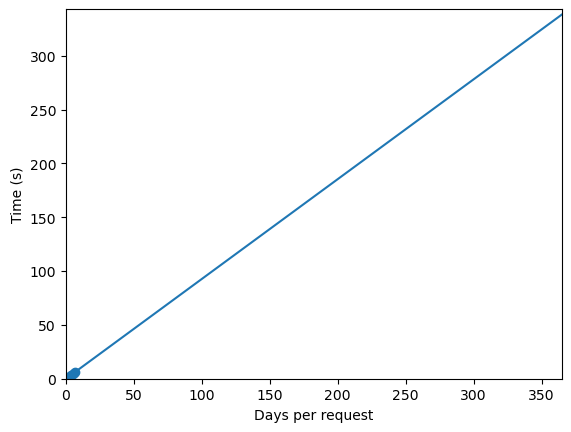

In [5]:
plot_and_return_year_timing("BPMS:L0B:0183:FW:X_SLOW")

368.171

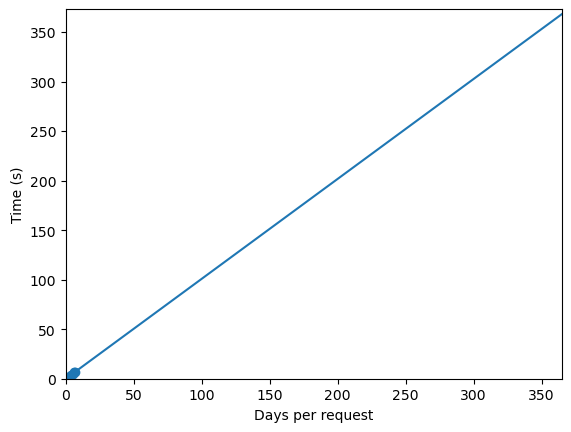

In [6]:
plot_and_return_year_timing("SOLN:GUNB:100:BACT")

While running this experiment, I discovered that there is another, even more limiting constraint. It is the amount of data that can be requested from the server. 

This occurs a lot earlier, and it results in a: 

`
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
--ServerApp.iopub_data_rate_limit.
`

This is unfortunate, as most users of this tool, like me, are probably going to use it in Jupyter Notebook, and I don't want to have users have to set config variables just to use my tool reliably. 

Goal: print out the amount of days, number of data points collected until the data rate is exceeded

In [7]:
def print_days_data_until_exceeded(pv_str : str): 
    for i in range(2, 30): 
        # set date interval
        start_str = "2024/04/01 00:00:00"
        if i < 10: 
            end_str = f"2024/04/0{i} 00:00:00"
        else: 
            end_str = f"2024/04/{i} 00:00:00"
        # format for the request function
        formatter = "%Y/%m/%d %H:%M:%S"
        start_obj = datetime.strptime(start_str, formatter)
        end_obj = datetime.strptime(end_str, formatter)
        # time the request
        start_timer = time.time()
        arch_data = arch.get_values_over_time_range([pv_str, pv_str], start_obj, end_obj)
        end_timer = time.time()
        # add the data point so it can be graphed
        time_request = round((end_timer - start_timer), 4)
        num_days = i - 1
        num_data_points = len(arch_data[pv_str].values)  # number of requested values
        print(f"Days: {num_days} | Points: {num_data_points} | Time: {time_request:.2f} s")

print_days_data_until_exceeded("BPMS:L0B:0183:FW:X_SLOW")

Days: 1 | Points: 114086 | Time: 0.91 s
Days: 2 | Points: 232020 | Time: 1.78 s
Days: 3 | Points: 350478 | Time: 2.47 s
Days: 4 | Points: 489878 | Time: 3.83 s
Days: 5 | Points: 635880 | Time: 4.58 s
Days: 6 | Points: 772930 | Time: 5.37 s
Days: 7 | Points: 916222 | Time: 6.43 s
Days: 8 | Points: 1015528 | Time: 7.39 s
Days: 9 | Points: 1049548 | Time: 7.49 s
Days: 10 | Points: 1049548 | Time: 7.38 s
Days: 11 | Points: 1081632 | Time: 7.73 s
Days: 12 | Points: 1235324 | Time: 8.83 s
Days: 13 | Points: 1378708 | Time: 10.33 s
Days: 14 | Points: 1520222 | Time: 11.06 s
Days: 15 | Points: 1656122 | Time: 12.07 s
Days: 16 | Points: 1805044 | Time: 13.34 s
Days: 17 | Points: 1944906 | Time: 14.66 s
Days: 18 | Points: 2062934 | Time: 14.80 s
Days: 19 | Points: 2151394 | Time: 15.32 s
Days: 20 | Points: 2282052 | Time: 16.18 s
Days: 21 | Points: 2430744 | Time: 17.89 s
Days: 22 | Points: 2530872 | Time: 18.30 s
Days: 23 | Points: 2548108 | Time: 18.60 s
Days: 24 | Points: 2548108 | Time: 17.7

It didn't throw an error, but the amount of data stopped increasing after day 26. All PVs have similar amount of data rates, but it's not consistent. One approach would be to see if it scales linearly, so that we could make a projection for every PV. 

Goal: get an estimate for how many days it will take to hit the hard cap. This is to test how accurate a prediction like this can be, compared to the previous data collection. 

In [13]:
def predict_days_data_until_exceeded(pv_str : str): 
    x = []
    y = []
    for i in range(2, 5): 
        # set date interval
        start_str = "2024/04/01 00:00:00"
        end_str = f"2024/04/0{i} 00:00:00"
        # format for the request function
        formatter = "%Y/%m/%d %H:%M:%S"
        start_obj = datetime.strptime(start_str, formatter)
        end_obj = datetime.strptime(end_str, formatter)
        # time the request
        start_timer = time.time()
        arch_data = arch.get_values_over_time_range([pv_str, pv_str], start_obj, end_obj)
        end_timer = time.time()
        # add the data point so it can be graphed
        time_request = round((end_timer - start_timer), 4)
        num_days = i - 1
        num_data_points = len(arch_data[pv_str].values)  # number of requested values
        print(f"Days: {num_days} | Points: {num_data_points} | Time: {time_request:.2f} s")
        # cache points for the estimate
        x.append(num_days)
        y.append(num_data_points)
    # want to know how many days it will take to hit the hard cap: when will y = 2.5E6? 
    m, b = np.polyfit(x, y, deg=1)
    days_to_exceeded = round(((2.5E6 - b) / m), 3)
    print(f"Days until cap exceeded: {days_to_exceeded}")

predict_days_data_until_exceeded("BPMS:L0B:0183:FW:X_SLOW")
# predict_days_data_until_exceeded("TORO:GUNB:360:CHRG")
# predict_days_data_until_exceeded("XCOR:GUNB:293:BACT")

Days: 1 | Points: 114086 | Time: 1.47 s
Days: 2 | Points: 232020 | Time: 2.51 s
Days: 3 | Points: 350478 | Time: 3.53 s
Days until cap exceeded: 21.187


Okay the prediction is somewhat accurate, and it gives an underestimate, which is good. I'll also limit the amount of requests to 2 million, so that should do the trick. 

Now I need to implement this in a function that makes an interval-based request using this calculation. 

Goal: project the amount of points for a given time period

In [9]:
def predict_points_for_timeframe(pv_str : str, start_time: str, end_time: str): 
    x = []
    y = []
    start_obj = datetime.strptime(start_time, format_string)
    end_obj = datetime.strptime(end_time, format_string)
    for i in range(1, 4): 
        # set date interval to be increasing longer by a day
        interval_obj = start_obj + timedelta(days=i)
        # time the request
        start_timer = time.time()
        arch_data = arch.get_values_over_time_range([pv_str], start_obj, interval_obj)
        end_timer = time.time()
        # add the data point so it can be graphed
        time_request = round((end_timer - start_timer), 4)
        num_days = i - 1
        num_data_points = len(arch_data[pv_str].values)  # number of requested values
        print(f"Days: {num_days} | Points: {num_data_points} | Time: {time_request:.2f} s")
        # cache points for the estimate
        x.append(num_days)
        y.append(num_data_points)
    # want to know how many data points generated in the given timeframe
    m, b = np.polyfit(x, y, deg=1)
    num_days = (end_obj - start_obj).days
    num_points_projected = float(m * num_days + b)
    # print(f"Num projected total points: {num_points_projected:.0f}")
    return int(round(num_points_projected))

predict_points_for_timeframe("BPMS:L0B:0183:FW:X_SLOW", "2024/06/01 00:00:00", "2024/06/30 00:00:00")

Days: 0 | Points: 79676 | Time: 0.68 s
Days: 1 | Points: 163201 | Time: 1.17 s
Days: 2 | Points: 230333 | Time: 1.95 s


2266935

We have a problem. This relationship is not linear at all. It seems that some months the archiver contains millions of data points. Other months, it contains thousands. This makes it difficult to filter out data. 

A potential solution could be to run this algorithm 1 month at a time, for each month in the timeframe.  

In [10]:
def predict_points_monthly_for_timeframe(pv_str: str, start_time: str, end_time: str): 
    # determine the amount of days between the start and end datetime 
    start_obj = datetime.strptime(start_time, format_string)
    end_obj = datetime.strptime(end_time, format_string)
    num_days = (end_obj - start_obj).days
    
    # every 30 days, predict how many points are generated for that period
    num_points = 0
    day_index = 0
    while day_index < num_days:
        current_time_obj = start_obj + timedelta(days=day_index)
        # if there are less than 30 days left, predict the amount of points generated for the remaining time 
        if day_index + 30 >= num_days: 
            num_points += predict_points_for_timeframe(pv_str, current_time_obj.strftime("%Y/%m/%d %H:%M:%S"), (current_time_obj + timedelta(days=(num_days - day_index))).strftime("%Y/%m/%d %H:%M:%S"))
            break
        if day_index % 30 == 0 or day_index == 1: 
            num_points += predict_points_for_timeframe(pv_str, current_time_obj.strftime("%Y/%m/%d %H:%M:%S"), (current_time_obj + timedelta(days=20)).strftime("%Y/%m/%d %H:%M:%S"))
            day_index += 30
    return num_points

predict_points_monthly_for_timeframe("BPMS:L0B:0183:FW:X_SLOW", "2024/06/01 00:00:00", "2024/07/01 00:00:00")

Days: 0 | Points: 79676 | Time: 0.66 s
Days: 1 | Points: 163201 | Time: 1.14 s
Days: 2 | Points: 230333 | Time: 1.71 s


2342263

Okay, this method works fairly well. It isn't tested, it half-broken, but it'll work for now. 

Later on we can add more guide rails to ensure it doesn't blow up, but that's a problem for a little later. Right now, we have a working function to get a projected amount of points for a given timeframe. 